In [110]:
%matplotlib inline
import chainer
from chainer import optimizers
import numpy as np
import csv
import math
import matplotlib.pyplot as plt
from net import Net

In [111]:
n_epoch = 10000 #エポック
batchsize = 20 #バッチサイズ
bprop_len = 100 #何回でバックプロパゲーションを打ち切るか(trancate)
n_units = 200 #中間層のユニット数
grad_clip = 5 #誤差関数の絶対値をこの値に制限する
use_gpu = False #GPUを使うかどうか

In [112]:
xp = cuda.cupy if use_gpu is True else np

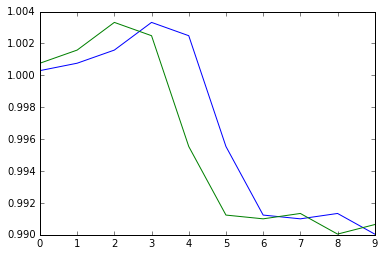

In [113]:
train_data_x = []
train_data_y = []
f = open('30minutes.csv','r')
data = csv.reader(f, delimiter=',')
for row in data:
    train_data_x.append(row[7])
    train_data_y.append(row[7])
raw_data = np.asarray(train_data_x, dtype=np.float32)
train_data_x = raw_data[:-1]
train_data_y = raw_data[1:]
plt.plot(train_data_x[:10])
plt.plot(train_data_y[:10])

In [114]:
#ネットワークを試す関数
def evaluate(model,num,origin=0):
    t = chainer.Variable(xp.array([[origin]],dtype=np.float32))
    output = []
    evaluator = model.copy()
    evaluator.reset_state()
    for i in range(num):
        t = evaluator.predict(t)
        output.append(t.data[0])
    return output

In [115]:
model = Net(1, n_units)#入力の次元数, 中間層の次元数
if use_gpu is True:
    model.to_gpu()
optimizer = optimizers.Adam()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.GradientClipping(grad_clip))
loss = []
length = len(train_data_x)
jump = length // batchsize
batch_idxs = list(range(batchsize))
accum_loss = 0
epoch = 0
loss_data = 0
for i in range(jump * n_epoch):
    x = chainer.Variable(xp.asarray([[train_data_x[(jump * j + i) % length]] for j in batch_idxs]))
    y = chainer.Variable(xp.asarray([[train_data_y[(jump * j + i) % length]] for j in batch_idxs]))
    loss_i = model(x,y)
    accum_loss += loss_i
    loss_data += accum_loss.data
        
    if (i+1) % jump == 0:
        epoch += 1
        if epoch % 10 == 0:
            print('epoch {}, error {}'.format(epoch, loss_data / length))
        loss.append(loss_data / length)
        loss_data = 0
        model.reset_state()
        
    
    if (i+1) % bprop_len == 0:
        model.zerograds()
        accum_loss.backward()
        accum_loss.unchain_backward()
        accum_loss = 0
        optimizer.update()

epoch 10, error 0.0007946015986383745
epoch 20, error 0.0004896636704238899
epoch 30, error 0.0006232844464356955
epoch 40, error 0.0053097846558660036
epoch 50, error 0.0018300214251033872
epoch 60, error 0.00033206711978715536
epoch 70, error 0.001739524027003375
epoch 80, error 0.0006211042507850454
epoch 90, error 0.000487963566987194
epoch 100, error 0.0005543763743789846
epoch 110, error 0.0004199081985852315
epoch 120, error 0.0004989153630091584
epoch 130, error 0.0002913512443103449
epoch 140, error 0.001165736436736342
epoch 150, error 0.0003341923841491358
epoch 160, error 0.00042849611921098543
epoch 170, error 0.00023184257611996787
epoch 180, error 0.0003488773000623552
epoch 190, error 0.0002159635469948104
epoch 200, error 0.00022726832652826442
epoch 210, error 0.00024298115369072076
epoch 220, error 0.0007733430133922856
epoch 230, error 0.0005454350683362607
epoch 240, error 0.00019120744818059104
epoch 250, error 0.00015976197286107115
epoch 260, error 0.00013364187

KeyboardInterrupt: 

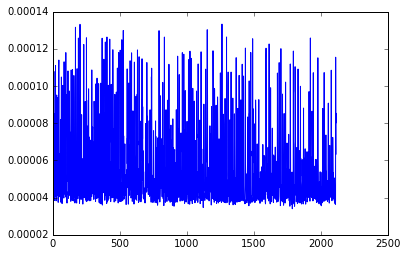

In [116]:
plt.plot(loss[1400:])

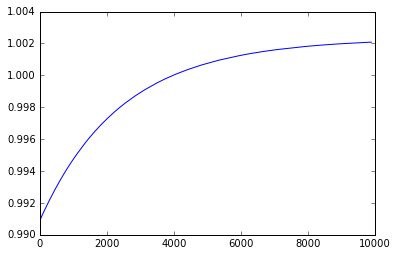

In [120]:
output = evaluate(model,10000,origin=1)
plt.plot(output[100:10000])